# model_B.ipynb
Author: Connacher Murphy

See documentation for a discussion of this implementation.

## 0. Libraries

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qsm_calibration as qsmc

## 1. Calibration
We create the commuting flows matrix $\mathbf{\pi}$, where $\pi_{i n}$ denotes the share of workers living in neighborhood $i$ commuting to neighborhood $n$.

In [130]:
( # calibrate() returns objects needed for models A and B
    pi,
    pi_cond,
    residents,
    workers,
    R_bar,
    wages,
    num_nbhd,
    far_southeast_indices,
    employment_core_indices,
    neighborhoods_shp,
    theta,
    alpha,
    beta,
) = qsmc.calibrate()

## 2. Counterfactual solver
Following the notation in the writeup, I let $i$ correspond to the first index and $n$ to the second.

In [131]:
def calc_sub_phi_hat(theta, alpha, w_hat, q_hat, kappa_hat, B_hat):
    """
    Calculate small phi
    Arguments:
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        w_hat: wage changes
        q_hat: rent changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
    """
    sub_phi_hat = (
        np.power(w_hat * np.power(q_hat, alpha - 1) / kappa_hat, theta) * B_hat
    )

    return sub_phi_hat


def calc_pi_hat(theta, alpha, pi_init, w_hat, q_hat, kappa_hat, B_hat):
    """
    Calculate change in unconditional commuting probabilities
    Arguments:
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        pi_init: unconditional commuting probabilities
        w_hat: wage changes
        q_hat: rent changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
    """
    sub_phi_hat = calc_sub_phi_hat(theta, alpha, w_hat, q_hat, kappa_hat, B_hat)
    pi_hat = sub_phi_hat / np.sum(pi_init * sub_phi_hat)

    return pi_hat


def calc_R_hat(
    theta, alpha, pi_init, R_init, R_bar_init, w_hat, q_hat, kappa_hat, B_hat, R_bar_hat
):
    """
    Calculate change in residential population
    Arguments:
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        pi_init: unconditional commuting probabilities
        R_init: residential population
        R_bar_init: population
        w_hat: wage changes
        q_hat: rent changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
        R_bar_hat: population change
    """
    pi_hat = calc_pi_hat(theta, alpha, pi_init, w_hat, q_hat, kappa_hat, B_hat)

    R_hat = (
        np.sum(pi_init * pi_hat, axis=1, keepdims=True)
        * R_bar_init
        * R_bar_hat
        / R_init
    )

    return R_hat


def calc_L_hat_supply(
    theta, alpha, pi_init, L_init, R_bar_init, w_hat, q_hat, kappa_hat, B_hat, R_bar_hat
):
    """
    Calculate change in labor supply
    Arguments:
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        pi_init: unconditional commuting probabilities
        L_init: workplace population
        R_bar_init: population
        w_hat: wage changes
        q_hat: rent changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
        R_bar_hat: population change
    """
    pi_hat = calc_pi_hat(theta, alpha, pi_init, w_hat, q_hat, kappa_hat, B_hat)

    L_hat = (
        np.sum(pi_init * pi_hat, axis=0, keepdims=True)
        * R_bar_init
        * R_bar_hat
        / L_init
    )

    return L_hat


def calc_agg_income_hat(
    theta,
    alpha,
    pi_init,
    w_init,
    w_hat,
    q_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
):
    """
    Calculate change in aggregate neighborhood income
    Arguments:
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        pi_init: unconditional commuting probabilities
        w_init: wages
        w_hat: wage changes
        q_hat: rent changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
        R_bar_hat: population change
    """
    pi_hat = calc_pi_hat(theta, alpha, pi_init, w_hat, q_hat, kappa_hat, B_hat)

    agg_income_hat = (
        R_bar_hat
        * np.sum(pi_init * pi_hat * w_init * w_hat, axis=1, keepdims=True)
        / np.sum(pi_init * w_init, axis=1, keepdims=True)
    )

    return agg_income_hat


def calc_q_hat(
    theta,
    alpha,
    pi_init,
    w_init,
    w_hat,
    q_hat,
    kappa_hat,
    B_hat,
    L_bar_hat,
    H_hat,
):
    """
    Calculate change in rents
    Arguments:
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        pi_init: unconditional commuting probabilities
        w_init: wages
        w_hat: wage changes
        q_hat: rent changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
        L_bar_hat: population change
        H_hat: housing stock changes
    """
    agg_income_hat = calc_agg_income_hat(
        theta, alpha, pi_init, w_init, w_hat, q_hat, kappa_hat, B_hat, L_bar_hat
    )

    q_hat = agg_income_hat / H_hat

    return q_hat


def calc_Z(
    w_tilde,
    q_tilde,
    theta,
    alpha,
    beta,
    pi_init,
    L_init,
    R_bar_init,
    A_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
):
    """
    Calculate calligraphic Z for candidate wage changes
    Arguments:
        w_tilde: candidate wage changes
        q_tilde: candidate rent changes
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        beta: elasticity of output with respect to labor
        pi_init: unconditional commuting probabilities
        L_init: workplace population
        R_bar_init: initial population
        A_hat: productivity changes
        kappa_hat: commuting cost changes
        H_hat: housing stock changes
    """

    demand_term = np.power(A_hat / w_tilde, 1 / (1 - beta))

    supply_term = calc_L_hat_supply(
        theta,
        alpha,
        pi_init,
        L_init,
        R_bar_init,
        w_tilde,
        q_tilde,
        kappa_hat,
        B_hat,
        R_bar_hat,
    )

    return demand_term - supply_term

In [132]:
# Unit test
# calc_Z should return all zeros if we guess the correct wage and rent changes
# We can set all parameter proportional changes to 1 (no changes) and check
# that a vector of unchanged wages and rents is an equilibrium
w_tilde = np.ones((1, num_nbhd))  # use the second index to follow tilde(w)_n notation
q_tilde = np.ones((num_nbhd, 1))
kappa_hat = np.ones((num_nbhd, num_nbhd))
B_hat = np.ones((num_nbhd, num_nbhd))
R_bar_hat = np.ones((1, 1))
H_hat = np.ones((num_nbhd, 1))
A_hat = np.ones((1, num_nbhd))

Z = calc_Z(
    w_tilde,
    q_tilde,
    theta,
    alpha,
    beta,
    pi,
    workers,
    R_bar,
    A_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
)

q_tilde_guess = calc_q_hat(
    theta,
    alpha,
    pi,
    wages,
    w_tilde,
    q_tilde,
    kappa_hat,
    B_hat,
    R_bar_hat,
    H_hat,
)

print(f"Maximum absolute value of Z_i: {abs(Z).max()}")
print(f"Maximum absolute difference in rents: {abs(q_tilde - q_tilde_guess).max()}")

print("Checking for nan values:")
print(f"Z: {np.sum(np.isnan(Z))}")
print(f"q_tilde: {np.sum(np.isnan(q_tilde_guess))}")

Maximum absolute value of Z_i: 7.771561172376096e-16
Maximum absolute difference in rents: 6.661338147750939e-16
Checking for nan values:
Z: 0
q_tilde: 0


In [133]:
def solve_counterfactual(
    num_nbhd,
    theta,
    alpha,
    beta,
    pi_init,
    w_init,
    L_init,
    R_bar_init,
    A_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
):
    """
    Solve for a counterfactual equilibrium with the exact hat system
    Arguments:
        num_nbhd: number of neighborhoods
        theta: preference shock dispersion parameter
        alpha: final good consumption share
        beta: elasticity of output with respect to labor
        pi_init: initial unconditional commuting probabilities
        L_init: initial workplace population
        R_bar_init: initial population
        A_hat: productivity changes
        kappa_hat: commuting cost changes
        B_hat: bilateral amenity changes
        R_bar_hat: population change
    """
    w_tilde = np.ones((1, num_nbhd))  # initial guess for wage changes
    q_tilde = np.ones((num_nbhd, 1))

    i = 0  # iteration counter
    error = 1.0  # initialize error
    tol = 1e-10  # error tolerance
    kappa = 0.1  # step size

    while error > tol:  # iterate until error is below tolerance
        # CM: where should I calculate q_tilde?

        Z = calc_Z(
            w_tilde,
            q_tilde,
            theta,
            alpha,
            beta,
            pi_init,
            L_init,
            R_bar_init,
            A_hat,
            kappa_hat,
            B_hat,
            R_bar_hat,
        )

        q_tilde_guess = calc_q_hat(
            theta,
            alpha,
            pi_init,
            w_init,
            w_tilde,
            q_tilde,
            kappa_hat,
            B_hat,
            R_bar_hat,
            H_hat,
        )

        w_tilde = w_tilde + (Z * kappa)  # update wage
        q_tilde = ((1 - kappa) * q_tilde) + (q_tilde_guess * kappa)

        error = np.absolute(Z).max()  # calculate error
        print("Step", i, "error:", round(error, 10))
        i += 1

    return w_tilde, q_tilde

In [134]:
# Run the unit test again, using the solve_counterfactual() function
w_hat, q_hat = solve_counterfactual(
    num_nbhd,
    theta,
    alpha,
    beta,
    pi,
    wages,
    workers,
    R_bar,
    A_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
)

print(f"Maximum absolute value of w_hat - 1: {abs(w_hat - 1).max()}")
print(f"Maximum absolute value of q_tilde - 1: {abs(q_hat - 1).max()}")

print("Checking for nan values:")
print(f"w_hat: {np.sum(np.isnan(w_hat))}")
print(f"q_hat: {np.sum(np.isnan(q_hat))}")

Step 0 error: 0.0
Maximum absolute value of w_hat - 1: 1.1102230246251565e-16
Maximum absolute value of q_tilde - 1: 0.0
Checking for nan values:
w_hat: 0
q_hat: 0


In [135]:
def summarize_counterfactual(num_nbhd, neighborhoods_shp, w_hat, q_hat, A_hat):
    df_hat = pd.DataFrame(  # stack wage and productivity changes into df
        np.column_stack(
            (
                w_hat.reshape((num_nbhd)),
                q_hat.reshape((num_nbhd)),
                A_hat.reshape((num_nbhd)),
            )
        ),
        columns=["w_hat", "q_hat", "A_hat"],
    )

    df_hat["id"] = df_hat.index + 1

    df_hat_shp = neighborhoods_shp.merge(  # merge with shapefile
        df_hat, on="id"
    )

    return df_hat_shp

## 3. Counterfactual exercises

### 3.i. Local productivity shock

In [136]:
print("Local productivity shock in far southeast")

A_hat[:, far_southeast_indices] = 1.05  # increase productivity by 5% in far southeast
w_hat, q_hat = solve_counterfactual(
    num_nbhd,
    theta,
    alpha,
    beta,
    pi,
    wages,
    workers,
    R_bar,
    A_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
)

productivity_shock_shp = summarize_counterfactual(
    num_nbhd, neighborhoods_shp, w_hat, q_hat, A_hat
)

Local productivity shock in far southeast
Step 0 error: 0.1297263219
Step 1 error: 0.055245033
Step 2 error: 0.0247329924
Step 3 error: 0.0118787025
Step 4 error: 0.0062592628
Step 5 error: 0.0036617894
Step 6 error: 0.0023617111
Step 7 error: 0.0016432314
Step 8 error: 0.0012031403
Step 9 error: 0.0009087003
Step 10 error: 0.0006986824
Step 11 error: 0.0005426069
Step 12 error: 0.0004237654
Step 13 error: 0.0003320169
Step 14 error: 0.0002606339
Step 15 error: 0.0002048514
Step 16 error: 0.0001611473
Step 17 error: 0.0001268514
Step 18 error: 9.99092e-05
Step 19 error: 7.87271e-05
Step 20 error: 6.2063e-05
Step 21 error: 4.8946e-05
Step 22 error: 3.86161e-05
Step 23 error: 3.04774e-05
Step 24 error: 2.40624e-05
Step 25 error: 1.9004e-05
Step 26 error: 1.50137e-05
Step 27 error: 1.1865e-05
Step 28 error: 9.3793e-06
Step 29 error: 7.4165e-06
Step 30 error: 5.8661e-06
Step 31 error: 4.641e-06
Step 32 error: 3.6726e-06
Step 33 error: 2.9071e-06
Step 34 error: 2.3016e-06
Step 35 error: 1.8

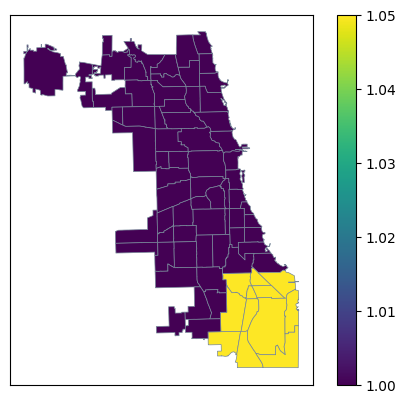

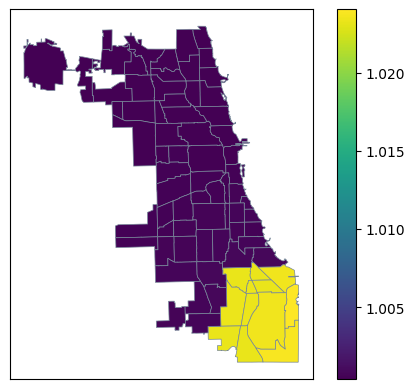

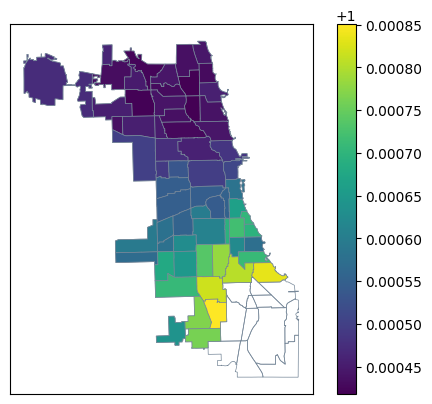

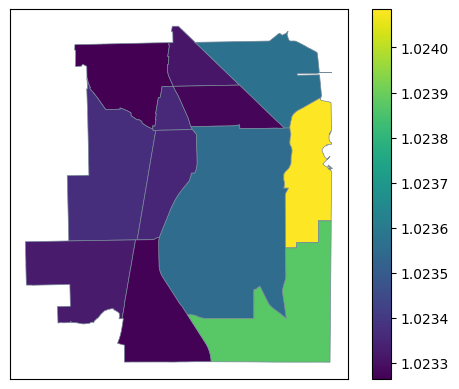

In [137]:
# Summarize results
figsize = (10, 10)

# A_hat
productivity_shock_shp.plot(
    column='A_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
# plt.title('$\\hat{A}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_A_hat.png')
plt.show()

# w_hat (all neighborhoods)
productivity_shock_shp.plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat.png')
plt.show()

# w_hat (exclude far southeast)
fig, ax = plt.subplots()

# Full boundaries
productivity_shock_shp.plot(
    facecolor='none', edgecolor='lightslategray', linewidth=0.5, ax=ax
)
# Exclude far southeast
productivity_shock_shp[productivity_shock_shp['far_southeast'] == 0].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5, ax=ax
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_censor.png')
plt.show()

# w_hat (only far southeast)
productivity_shock_shp[productivity_shock_shp['far_southeast'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_focus.png')
plt.show()

### 3.ii. Employment core transportation shock

In [138]:
# Reset A_hat
A_hat = np.ones((1, num_nbhd))

# Reduce travel costs from far Southeast to employment core by 5%
kappa_hat[far_southeast_indices.reshape(-1, 1), employment_core_indices] = 0.95

w_hat, q_hat = solve_counterfactual(
    num_nbhd,
    theta,
    alpha,
    beta,
    pi,
    wages,
    workers,
    R_bar,
    A_hat,
    kappa_hat,
    B_hat,
    R_bar_hat,
)
transport_shock_shp = summarize_counterfactual(num_nbhd, neighborhoods_shp, w_hat, q_hat, A_hat)

Step 0 error: 0.0054534723
Step 1 error: 0.0085197494
Step 2 error: 0.0085092796
Step 3 error: 0.0074774635
Step 4 error: 0.0062299619
Step 5 error: 0.0050614836
Step 6 error: 0.0040609327
Step 7 error: 0.003237642
Step 8 error: 0.0025731725
Step 9 error: 0.0020420397
Step 10 error: 0.0016195214
Step 11 error: 0.0012841779
Step 12 error: 0.0010182894
Step 13 error: 0.0008075422
Step 14 error: 0.0006405033
Step 15 error: 0.0005080905
Step 16 error: 0.0004031065
Step 17 error: 0.0003198533
Step 18 error: 0.000253821
Step 19 error: 0.0002014388
Step 20 error: 0.0001598792
Step 21 error: 0.0001269024
Step 22 error: 0.0001007331
Step 23 error: 7.99644e-05
Step 24 error: 6.34805e-05
Step 25 error: 5.03966e-05
Step 26 error: 4.00109e-05
Step 27 error: 3.17665e-05
Step 28 error: 2.52217e-05
Step 29 error: 2.0026e-05
Step 30 error: 1.5901e-05
Step 31 error: 1.26261e-05
Step 32 error: 1.0026e-05
Step 33 error: 7.9615e-06
Step 34 error: 6.3223e-06
Step 35 error: 5.0207e-06
Step 36 error: 3.9872e-

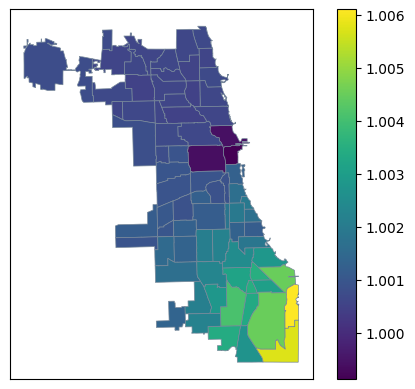

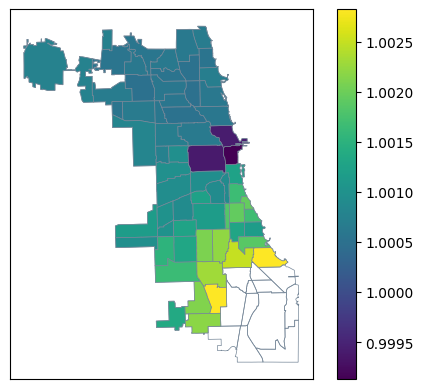

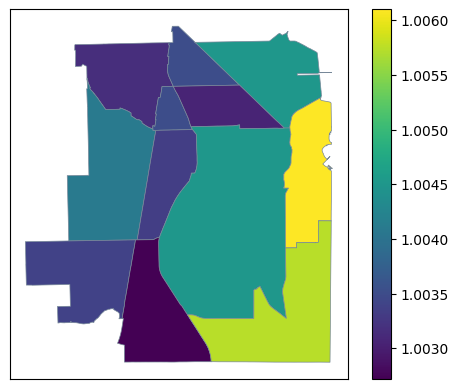

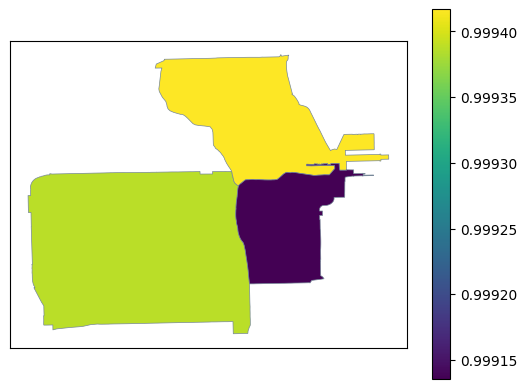

In [139]:
# w_hat (all neighborhoods)
transport_shock_shp.plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat.png')
plt.show()

# w_hat (exclude far southeast)
fig, ax = plt.subplots()

# Full boundaries
transport_shock_shp.plot(
    facecolor='none', edgecolor='lightslategray', linewidth=0.5, ax=ax
)
# Exclude far southeast
transport_shock_shp[productivity_shock_shp['far_southeast'] == 0].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5, ax=ax
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_censor.png')
plt.show()

# w_hat (only far southeast)
transport_shock_shp[transport_shock_shp['far_southeast'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_focus.png')
plt.show()

# w_hat (only loop)
transport_shock_shp[transport_shock_shp['employment_core'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/transport_shock_w_hat_focus_core.png')
plt.show()